In [1]:
import yaml
import numpy as np
from trace_IO import *
from OptimumFilter import *
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
sub_template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)
vac_of = OptimumFilter(vac_template, noise_psd, sampling_frequency)
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

In [17]:
trace, idx= lts.generate(
            E=50,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]
amps = []
chisqs = []
shifts = []
positions = []
significant_fits = []
channels = []
all_fit_results = []

# These are for plotting
sub_deltas = []
sub_chisqs = []
vac_deltas = []
vac_chisqs = []

for ch in range(54):
    if ch < 45:
        ampl, chisq, shift, position = sub_of.rolling_fit_with_shift(trace[ch], allowed_shift_range=None)
    else:
        ampl, chisq, shift, position = vac_of.rolling_fit_with_shift(trace[ch], allowed_shift_range=None)
    
    # Store raw arrays
    amps.append(ampl)
    chisqs.append(chisq)
    shifts.append(shift)
    positions.append(position)
    
    # Store per-channel fits for later analysis
    fit_results = [
        {'channel': ch, 'amplitude': a, 'shift': s, 'chisq': c, 'position': p}
        for a, s, c, p in zip(ampl, shift, chisq, position)
    ]
    all_fit_results.extend(fit_results)


In [18]:
print("=== Fits with |position - idx| > 5000 and amplitude > 4 ===")
threshold = 4.8
for res in all_fit_results:
    pos_error = res['position'] - idx
    amp = res['amplitude']
    ch = res['channel']
    chisq = res['chisq']
    shift_val = res['shift']  # <- Extract the shift here

    if amp > threshold:
        # Check if any other fit in the same channel (excluding this one) has amp > 4
        other_fits = [r for r in all_fit_results if r['channel'] == ch and r != res]
        has_other_significant = any(r['amplitude'] > threshold for r in other_fits)

        print(f"Channel {ch} | Amplitude: {amp:.2f}, Chi²: {chisq:.2f}, Error: {pos_error}, Shift: {shift_val}, Other fit passed?: {has_other_significant}")


=== Fits with |position - idx| > 5000 and amplitude > 4 ===
Channel 20 | Amplitude: 31.35, Chi²: 0.95, Error: -10, Shift: 2366, Other fit passed?: False
Channel 23 | Amplitude: 33.55, Chi²: 0.95, Error: -3, Shift: 2373, Other fit passed?: False


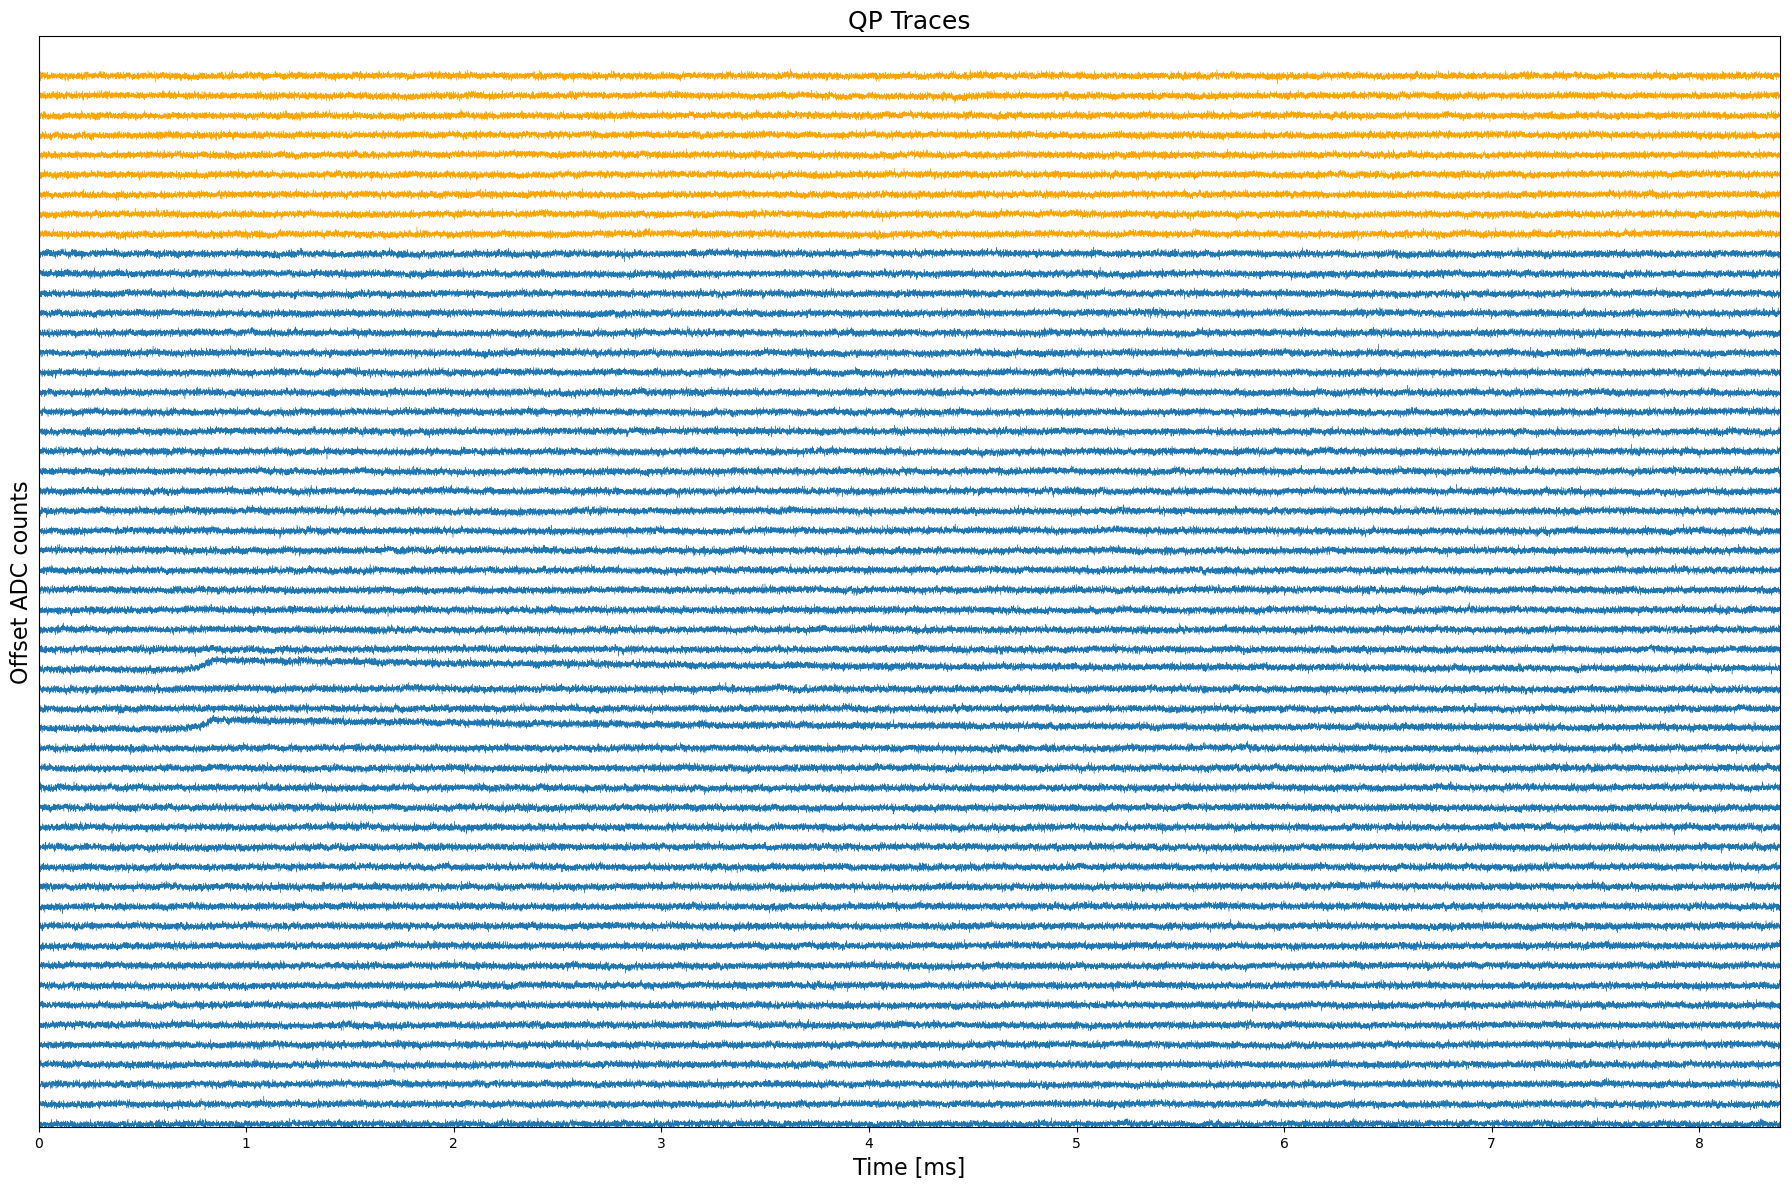

In [19]:
plot_traces(trace[:, idx : idx + 32768])